# Hebb's learning
- Basic neuron
  - load XML, rescale
  - generate random values that are linearly separable in R^2 (0;1)
- plot points
- learn
- plot points with neuron's line

In [1]:
import numpy as np
import math
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [9]:
plt.style.use("ggplot")

In [3]:
def parse_xml(filename):
    def parse_inputs(perceptron):
        for input in perceptron.findall("inputDescriptions"):
            yield {
                'min': float(input.find('minimum').text),
                'max': float(input.find('maximum').text),
                'name': input.find('name').text
            }
            
    def parse_dataset_x(dataset):
        for element in dataset.findall("element"):
            x = list(map(lambda value: float(value.text), element.find("inputs").findall("value")))
            yield x
            
    def parse_dataset_y(dataset):
        for element in dataset.findall("element"):
            y = float(element.find("output").text)
            yield y
    
    tree = ET.parse(f"{filename}")
    root = tree.getroot()
    inputs = list(parse_inputs(root.find("perceptron")))
    train_x = list(parse_dataset_x(root.find("TrainSet")))
    train_y = list(parse_dataset_y(root.find("TrainSet")))
    test = list(parse_dataset_x(root.find("TestSet")))
    
    return (inputs, (train_x, train_y), test)

In [4]:
def rescale(inputs, dataset):    
    result = []
    for x in dataset:
        record = []
        for i, xi in enumerate(x):
            min = inputs[i]["min"]
            max = inputs[i]["max"]
            record.append((xi - min) / (max - min))
        result.append(record)
    return result

In [5]:
def plot_train(x, y):
    x0 = list(map(lambda x: x[0], x))
    x1 = list(map(lambda x: x[1], x))
    
    x0a, x1a = [], [] # 0
    x0b, x1b = [], [] # 1
    for xi, y in zip(x, y):
        if y == 0:
            x0a.append(xi[0])
            x1a.append(xi[1])
        else:
            x0b.append(xi[0])
            x1b.append(xi[1])
    
    plt.scatter(x0a, x1a, marker="o", label="train 0", c="r")
    plt.scatter(x0b, x1b, marker="x", label="train 1", c="b")
    
def plot_test(x):
    x0 = list(map(lambda x: x[0], x))
    x1 = list(map(lambda x: x[1], x))
    plt.scatter(x0, x1, s=100, marker="$?$", label="test", c="k")
    
def plot_predicted(x, y):
    x0 = list(map(lambda x: x[0], x))
    x1 = list(map(lambda x: x[1], x))
    
    x0a, x1a = [], [] # 0
    x0b, x1b = [], [] # 1
    for xi, y in zip(x, y):
        if y == 0:
            x0a.append(xi[0])
            x1a.append(xi[1])
        else:
            x0b.append(xi[0])
            x1b.append(xi[1])
    
    plt.scatter(x0a, x1a, marker="o", label="predict 0", c="r", s=100)
    plt.scatter(x0b, x1b, marker="x", label="predict 1", c="b", s=100)
    
def plot_space(neuron):
    step = 0.0025
    x0, x1 = np.meshgrid(np.arange(0, 1+step, step), np.arange(0, 1+step, step))
    data_x = np.c_[x0.flatten(), x1.flatten()]
    data_y = np.array(neuron.predict(data_x))

    plt.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r, alpha=0.25)

In [50]:
class Neuron:
    def __init__(self, n):
        self.n = n
        self.w = np.random.rand(n + 1)
        self.w[0] = 1
        
    def train(self, data_x, data_y, learning_rate=0.2):
        epoch = 0
        while True:
            epoch += 1
            wrong = 0
            for input, y_expected in zip(data_x, data_y):
                #print(f"input = {input}, expected output = {y_expected}")
                x = np.append([1], input)
                #print(f"x = {x}")
                y_real = self._predict(x)
                #print(f"actual output = {y_real}")
                delta = y_expected - y_real
                
                if delta != 0:
                    wrong += 1

                #print(f"delta = {delta}")
                #print(f"before = {self.w}")
                self.w = self.w + learning_rate * delta * x
                #print(f"after = {self.w}")
            
            print(f"epoch = {epoch}, score={len(data_x) - wrong}/{len(data_x)}")
            if wrong == 0:
                break
                
    def train_single(self, data_x, data_y, learning_rate=0.2):
        ok = 0
        for input, y_expected in zip(data_x, data_y):
            x = np.append([1], input)
            y_real = self._predict(x)
            delta = y_expected - y_real
            if delta == 0:
                ok += 1
            self.w = self.w + learning_rate * delta * x
        return ok / len(data_x)
    
    def score(self, data_x, data_y):
        ok = 0
        for input, y_expected in zip(data_x, data_y):
            x = np.append([1], input)
            y_real = self._predict(x)
            if y_expected == y_real:
                ok += 1
        return ok / len(data_x)
        
    def predict(self, inputs):
        predictions = []
        for input in inputs:
            x = np.append([1], input)
            predicted = self._predict(x)
            predictions.append(predicted)
        return predictions
    
    def _predict(self, x):        
        y = np.dot(self.w, x)
        y = self._sign(y)
        return y
    
    def _sign(self, x):
        return 0 if x <= 0 else 1

In [7]:
def solve(filename):
    inputs, (train_x, train_y), test = parse_xml(filename)
    
    #print(inputs, train_x, train_y, test)
    
    input_dim = len(inputs)
    
    if input_dim == 2:
        fig = plt.figure(figsize=(24, 8))
        fig.suptitle(filename)
        plt.subplot(1, 3, 1)
        plt.title("original")
        plot_train(train_x, train_y)
        plot_test(test)
        plt.legend()
    
    train_x = rescale(inputs, train_x)
    test = rescale(inputs, test)
    
    if input_dim == 2:
        plt.subplot(1, 3, 2)
        plt.title("rescaled")
        plot_train(train_x, train_y)
        plot_test(test)
        plt.legend()
    
    
    neuron = Neuron(input_dim)
    
    neuron.train(train_x, train_y)
        
    if input_dim == 2:
        plt.subplot(1, 3, 3)
        plt.title("result")
        plot_space(neuron)
        plot_train(train_x, train_y)
        plot_predicted(test, neuron.predict(test))
        
        plt.legend()
        plt.show()
        
    #print(neuron.w)

#solve("obdelnik_rozsah.xml")
#solve("t2r.xml")

obdelnik_rozsah.xml
epoch = 1, score=3/6
epoch = 2, score=2/6
epoch = 3, score=1/6
epoch = 4, score=4/6
epoch = 5, score=4/6
epoch = 6, score=6/6


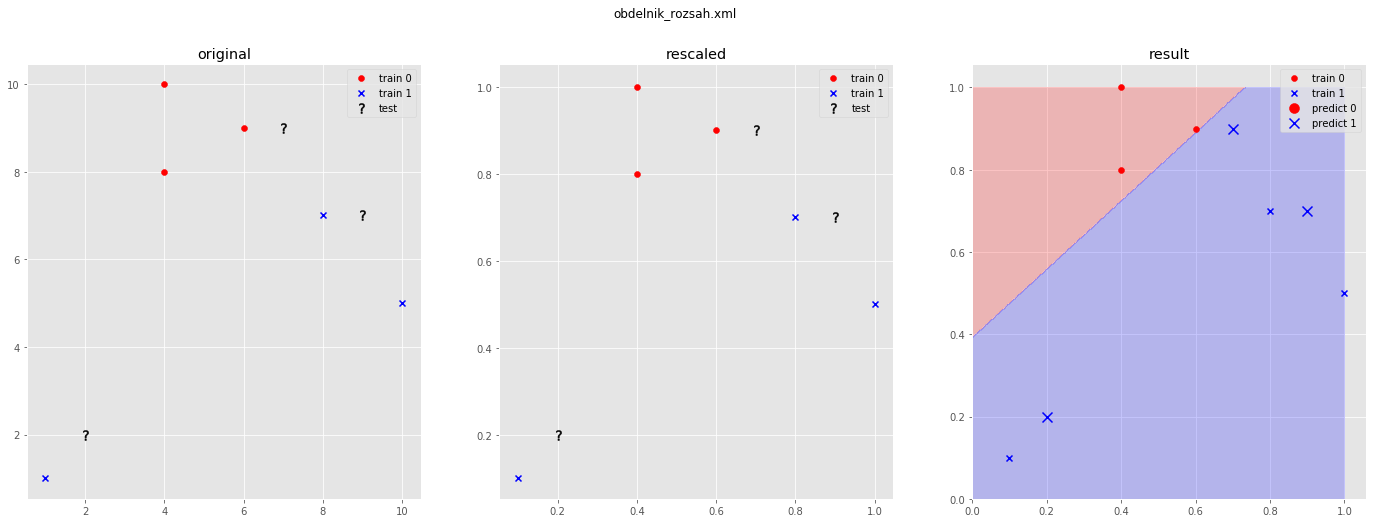

t1r.xml
epoch = 1, score=3/6
epoch = 2, score=3/6
epoch = 3, score=4/6
epoch = 4, score=4/6
epoch = 5, score=4/6
epoch = 6, score=4/6
epoch = 7, score=6/6


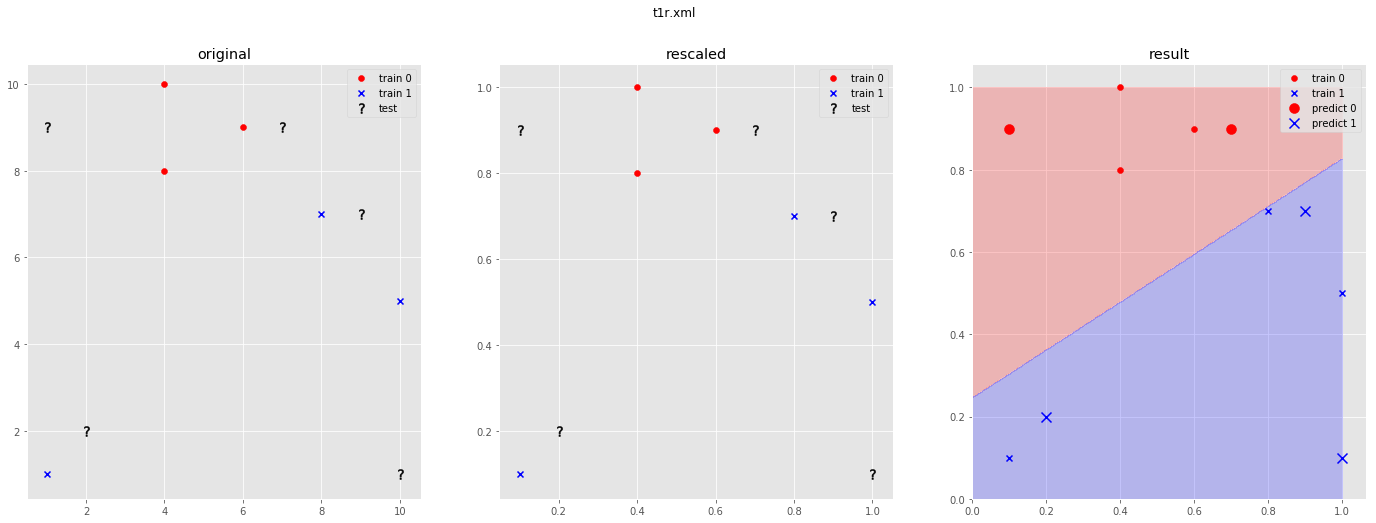

t2r.xml
epoch = 1, score=3/6
epoch = 2, score=2/6
epoch = 3, score=5/6
epoch = 4, score=6/6


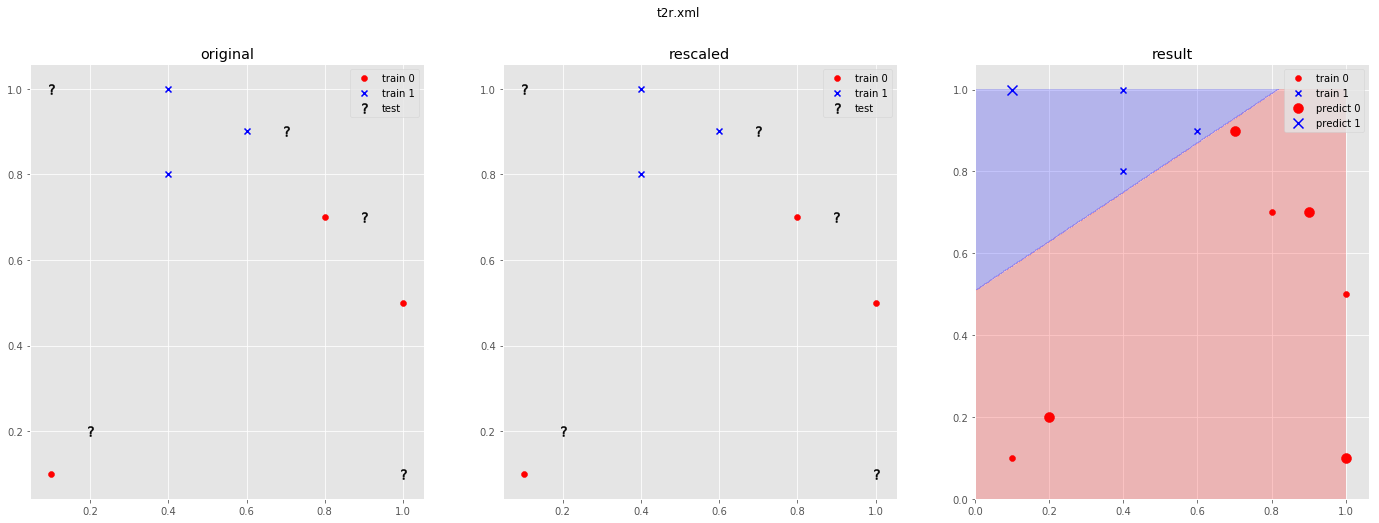

t3r.xml
epoch = 1, score=6/11
epoch = 2, score=7/11
epoch = 3, score=9/11
epoch = 4, score=7/11
epoch = 5, score=9/11
epoch = 6, score=9/11
epoch = 7, score=8/11
epoch = 8, score=9/11
epoch = 9, score=9/11
epoch = 10, score=9/11
epoch = 11, score=9/11
epoch = 12, score=9/11
epoch = 13, score=9/11
epoch = 14, score=9/11
epoch = 15, score=9/11
epoch = 16, score=9/11
epoch = 17, score=9/11
epoch = 18, score=9/11
epoch = 19, score=9/11
epoch = 20, score=9/11
epoch = 21, score=9/11
epoch = 22, score=9/11
epoch = 23, score=10/11
epoch = 24, score=11/11


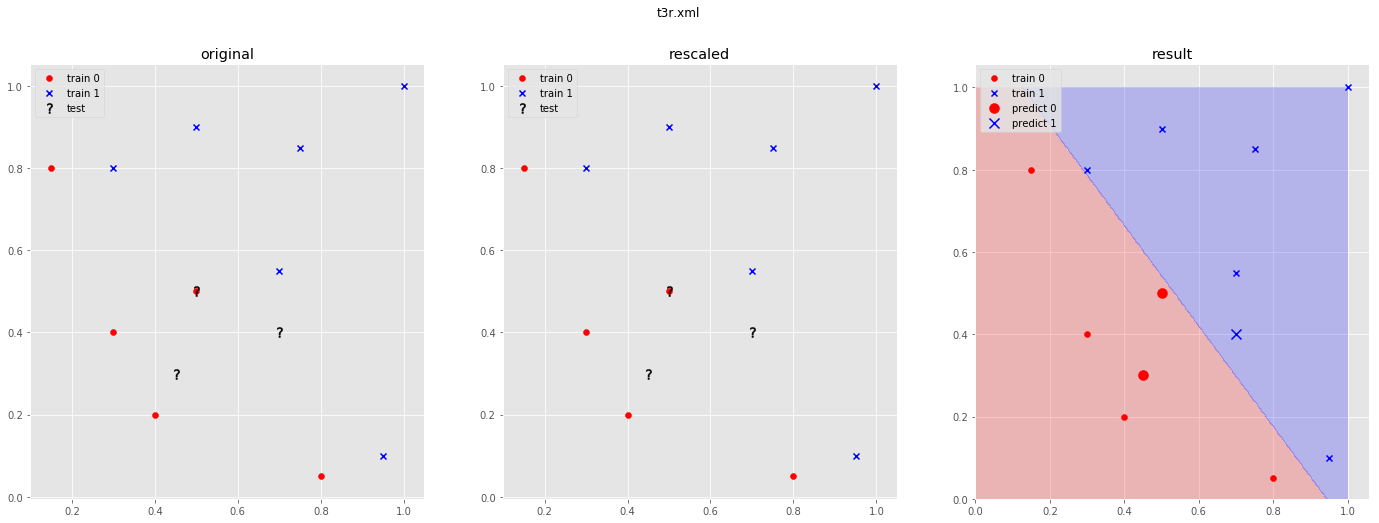

t4r.xml
epoch = 1, score=4/10
epoch = 2, score=3/10
epoch = 3, score=6/10
epoch = 4, score=6/10
epoch = 5, score=9/10
epoch = 6, score=10/10
t5r.xml
epoch = 1, score=6/11
epoch = 2, score=7/11
epoch = 3, score=7/11
epoch = 4, score=8/11
epoch = 5, score=9/11
epoch = 6, score=9/11
epoch = 7, score=9/11
epoch = 8, score=9/11
epoch = 9, score=9/11
epoch = 10, score=9/11
epoch = 11, score=9/11
epoch = 12, score=9/11
epoch = 13, score=9/11
epoch = 14, score=9/11
epoch = 15, score=9/11
epoch = 16, score=9/11
epoch = 17, score=9/11
epoch = 18, score=9/11
epoch = 19, score=10/11
epoch = 20, score=11/11


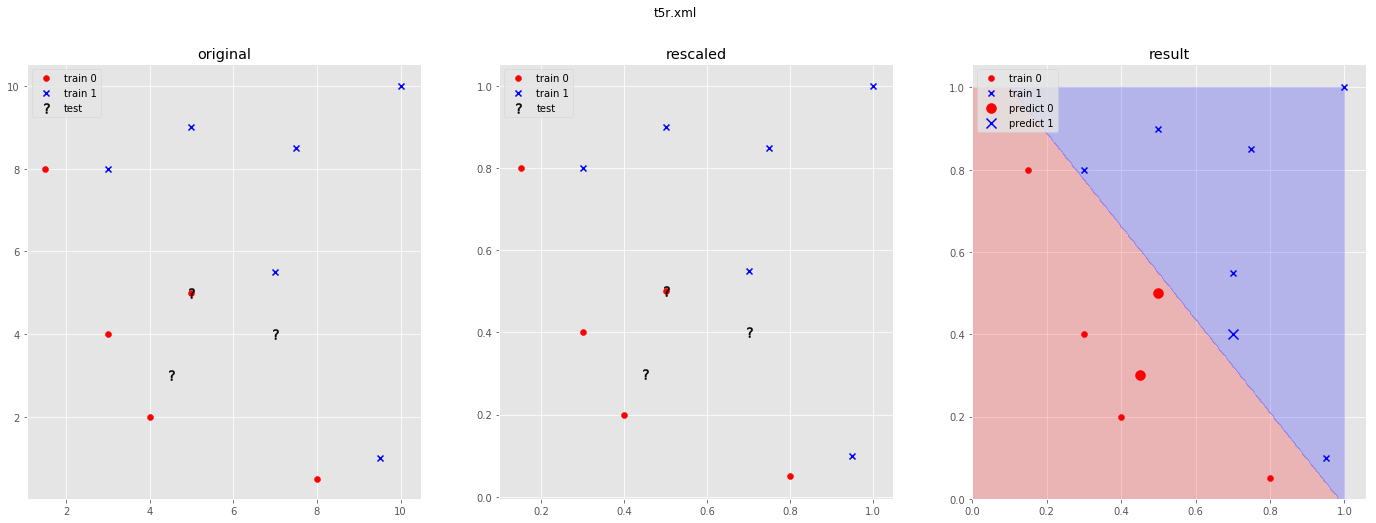

t6r.xml
epoch = 1, score=6/11
epoch = 2, score=9/11
epoch = 3, score=9/11
epoch = 4, score=9/11
epoch = 5, score=9/11
epoch = 6, score=9/11
epoch = 7, score=9/11
epoch = 8, score=9/11
epoch = 9, score=7/11
epoch = 10, score=9/11
epoch = 11, score=9/11
epoch = 12, score=9/11
epoch = 13, score=9/11
epoch = 14, score=9/11
epoch = 15, score=8/11
epoch = 16, score=9/11
epoch = 17, score=9/11
epoch = 18, score=9/11
epoch = 19, score=9/11
epoch = 20, score=9/11
epoch = 21, score=9/11
epoch = 22, score=9/11
epoch = 23, score=9/11
epoch = 24, score=9/11
epoch = 25, score=7/11
epoch = 26, score=9/11
epoch = 27, score=9/11
epoch = 28, score=9/11
epoch = 29, score=9/11
epoch = 30, score=10/11
epoch = 31, score=11/11


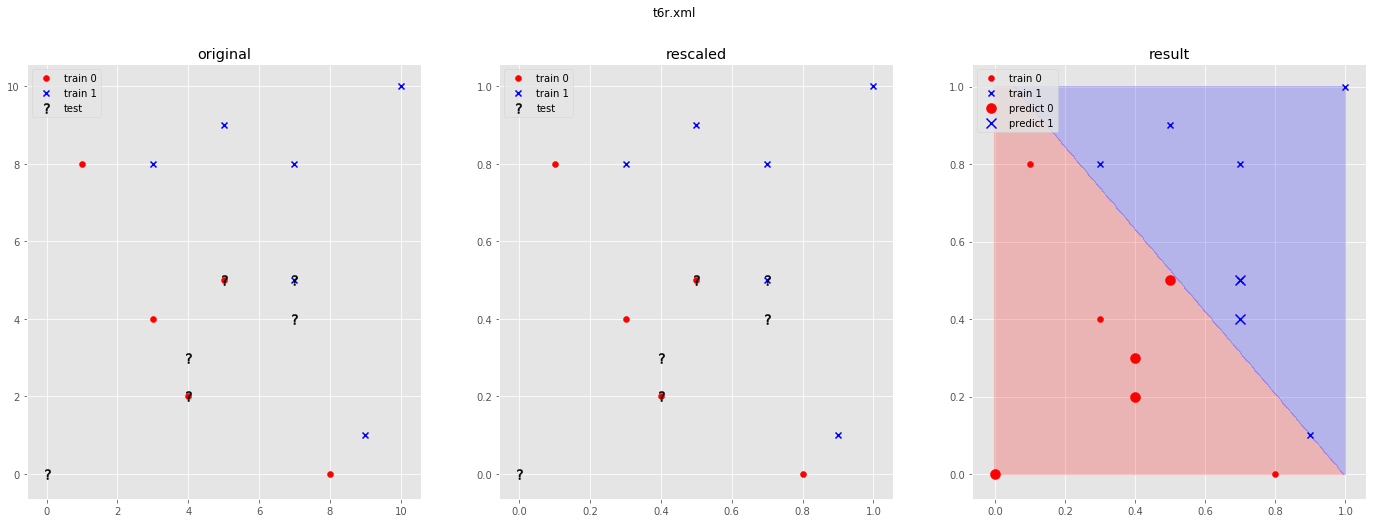

t7r.xml
epoch = 1, score=6/11
epoch = 2, score=7/11
epoch = 3, score=8/11
epoch = 4, score=9/11
epoch = 5, score=10/11
epoch = 6, score=11/11


In [87]:
files = ["obdelnik_rozsah.xml", "t1r.xml", "t2r.xml", "t3r.xml", "t4r.xml", "t5r.xml", "t6r.xml", "t7r.xml"]
for file in files:
    print(file)
    solve(file)

In [72]:
def generate_training_animation(filename):
    inputs, (train_x, train_y), test = parse_xml(filename)

    input_dim = len(inputs)
    if input_dim != 2:
        return

    train_x = rescale(inputs, train_x)
    test = rescale(inputs, test)

    neuron = Neuron(input_dim)

    fig, ax = plt.subplots()

    step = 0.005
    x0, x1 = np.meshgrid(np.arange(0, 1+step, step), np.arange(0, 1+step, step))
    data_x = np.c_[x0.flatten(), x1.flatten()]
    data_y = np.array(neuron.predict(data_x))
    ax.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r, alpha=0.25)


    train_x0 = list(map(lambda x: x[0], train_x))
    train_x1 = list(map(lambda x: x[1], train_x))
    train_x0a, train_x1a = [], [] # 0
    train_x0b, train_x1b = [], [] # 1
    for xi, y in zip(train_x, train_y):
        if y == 0:
            train_x0a.append(xi[0])
            train_x1a.append(xi[1])
        else:
            train_x0b.append(xi[0])
            train_x1b.append(xi[1])


    def animate(epoch):
        ax.clear()
        ax.set_title(f"{filename} - Epoch {epoch}")
        data_y = np.array(neuron.predict(data_x))
        ax.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r, alpha=0.25)

        ax.scatter(train_x0a, train_x1a, marker="o", label="train 0", c="r")
        ax.scatter(train_x0b, train_x1b, marker="x", label="train 1", c="b")

        return fig,

    def frames():
        epoch = 0
        while True:
            score = neuron.train_single(train_x, train_y, learning_rate=0.05)
            if epoch != 0 and score == 1:
                return
            epoch += 1
            yield epoch


    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=300, blit=True)

    ani.save(f"{filename}.gif")

In [ ]:
files = ["obdelnik_rozsah.xml", "t1r.xml", "t2r.xml", "t3r.xml", "t4r.xml", "t5r.xml", "t6r.xml", "t7r.xml"]
for file in files:
    generate_training_animation(file)